# 基于神经网络算法的用电量预测

作者信息：linsl1986 (https://github.com/linsl1986)

我在AI Studio上获得白银等级，点亮1个徽章，来互关呀~ https://aistudio.baidu.com/aistudio/personalcenter/thirdview/134639

## 1. 简要介绍
    开展电力系统用电量及负荷预测的目的是：为了电力系统供电范围内电力工业的发展能够适应国民经济和社会发展的需要。
    用电量及负荷预测是电力工业生产建设计划及经营管理的基础，又是电力系统规划设计的基础。
    本项目以A地区一年的用电量和相应的气象因素为依据，使用神经网络算法进行电量及负荷预测。

## 2. 环境设置
导入包，设置所用的归一化方法、神经网络结构、训练轮数和预测时间段等信息


In [1]:
import pandas as pd
import numpy as np
import paddle
import paddle.fluid as fluid
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
# 选择归一化方法
normalization=1 # 0表示Max-min归一化， 1表示Zscore归一化
# 选择神经网络
flag = 0 # 0表示全连接神经网络， 1表示LSTM神经网络
day_num = 1 # 选择前一天的特征作为输入数据。
# 训练参数设置
BATCH_SIZE = 5
learning_rate = 0.001
EPOCH_NUM = 200

# 可视化天数选择，建议大于7，这样才能展示一周的预测情况
date_n = 7

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized



## 3. 数据集
本数据集包含了近一年A地区用电量以及气象要素的原始数据，每天有96个时刻的温度，湿度，风速，降雨和用电量。
具体步骤包括：

1、从excel中读取数据

![](https://ai-studio-static-online.cdn.bcebos.com/aca97352225f44b59160f47217934a31cb28e7c3b33341e9a8d549caae031145)

2、划分训练集和测试集。由于本项目是基于N天的用电量和气象要素等信息预测N+1天的用电量，因此训练集和测试集的数据是需要连续若干天的，这里有别于多元线性回归时的训练集和测试集的划分过程。

![](https://ai-studio-static-online.cdn.bcebos.com/67cebd27a423473393cd7f8447e0a1c19d7ef6dd85c74d1db6267aba88a7b996)


3、数据集调整思路
* 减少特征，也就是不考虑温度，湿度，风速，降雨和负荷数据中的一种或者多种，重新构建输入特征
* 使用前几天的数据预测性后一天的负荷，修改上面的day_num数值
* 由于温度，湿度，风速，降雨等数据是可以预测得到的，因此在输入特征中添加后一天的温度，湿度，风速，降雨。

讲述数据集的一些基础信息，描述数据集组成等。进行数据集的下载、抽样查看、数据集定义等。



In [2]:
#  从excel中读取温度，湿度，风速，降雨和用电量数据
train_set = []
test_set = []
for i in range(5):
    sheet = pd.read_excel('work/Load_Forcast.xlsx',
            sheet_name = i,usecols = range(1,97))
    train_set.append(sheet[0:365].values)#对应excel中的第2行到366行
    test_set.append(sheet[365:365+31].values)#对应excel中第367行到397行
print(train_set[0].shape)
print(test_set[0].shape)

(365, 96)
(31, 96)


In [3]:
#生成训练集和测试集
def data_pro(train_set, test_set, day_num):
    # 定义训练标签数据
    train_y = train_set[4]
    # 数据为一年的用电量数据，共365天，由于前一天day_num的数据作为输入，因此需要删去第一天的数据
    train_y =  train_y[day_num:, :]
    print(train_y.shape)
   # print(train_y[0]) #检验是否已经删除了第一天的数据

    # 选择特征，定义训练的输入数据
    # train_set[0]表示温度数据,train_set[1]：表示湿度数据,train_set[2]：表示风速数据, train_set[3]：表示降雨数据， train_set[4]：表示用电量数据， 

   
    temperature_data   = train_set[0]
    humidity_data      = train_set[1]
    wind_velocity_data = train_set[2]
    rainfall_data      = train_set[3]
    load_data          = train_set[4]

    # 将温度，湿度，风速，降雨，用电量合并，成为输入的特征向量，所以有96*5=480列数据
    train_x_temp = np.concatenate((temperature_data,humidity_data, wind_velocity_data, rainfall_data, load_data),axis = 1)
    temp = []
    for x in range(day_num):
        temp.append(train_x_temp[x:(365-day_num+x), :]) # 训练集的输入train_x中删除第一年的最后一天的数据
    
    train_x = np.concatenate(temp, axis=1)
    print(train_x.shape)
   # print(train_x[363])#检验训练集的输入train_x最后一组数据


    # 根据选择特征的定义，修改测试集的数据
    # 修改测试集的标签数据
    test_y = test_set[0-day_num]
    test_y = test_y[day_num:, :]
    print(test_y.shape)
    # 修改测试集的输入数据
    temperature_data   = test_set[0]
    humidity_data      = test_set[1]
    wind_velocity_data = test_set[2]
    rainfall_data      = test_set[3]
    load_data          = test_set[4]
    test_x_temp = np.concatenate((temperature_data,humidity_data, wind_velocity_data, rainfall_data, load_data),axis = 1)

    temp = []
    for x in range(day_num):
        temp.append(test_x_temp[x:(31-day_num+x), :])
        # print(test_x_temp[x:(31-day_num+x), :].shape)
    
    test_x = np.concatenate(temp, axis=1)
    print(test_x.shape)


    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = data_pro(train_set=train_set, test_set=test_set, day_num=day_num)

(364, 96)
(364, 480)
(30, 96)
(30, 480)


In [4]:
#本部分为数据归一化的代码，一般不需要修改
if normalization==0: # 使用Max-min归一化处理函数
     def normalization_Maxmin(train_x):
         Min = np.min(train_x, axis=0)
         Max = np.max(train_x, axis=0)
         train_x = (train_x-Min)/ (Max - Min)
         # 处理异常情况
         train_x[np.isnan(train_x)] = 0
         train_x[np.isinf(train_x)] = 0
         return train_x, Min, Max

    # 对输入数据进行归一化处理
     train_x, Min_x, Max_x = normalization_Maxmin(train_x)
     test_x = (test_x -Min_x)/ (Max_x - Min_x)
    # 对输出数据进行归一化处理
     train_y, Min_y, Max_y = normalization_Maxmin(train_y)
     test_y = (test_y-Min_y)/ (Max_y - Min_y)
else:#zscore归一化处理函数，适用于数据服从正态分布
     def normalization_zscore(train_x):
         mu = np.mean(train_x, axis=0)
         sigma = np.std(train_x, axis=0)
         train_x = (train_x-mu)/sigma
         # 处理异常情况
         train_x[np.isnan(train_x)] = 0
         train_x[np.isinf(train_x)] = 0
         return train_x, mu, sigma

    # 对输入数据进行归一化处理
     train_x, mu_x, sgma_x = normalization_zscore(train_x)
     test_x = (test_x - mu_x)/sgma_x
    # 对输出数据进行归一化处理
     train_y, mu_y, sgma_y = normalization_zscore(train_y)
     test_y = (test_y-mu_y)/sgma_y

## 4. 模型组网
下面的示例中，使用全连接神经网络，可以修改成其他神经网络，例如LSTM。**注意，因为预测的负荷十五分钟一个时刻，一天共96个时刻，所以输出的维度必须为96。**



In [5]:
# 定义全连接神经网络 
def Full_connected(input): 
    hidden1 = fluid.layers.fc(input=input, size=50, act='relu') 
    hidden2 = fluid.layers.fc(input=hidden1, size=50, act='relu')
    hidden3 = fluid.layers.fc(input=hidden2, size=50, act='relu')
    hidden4 = fluid.layers.fc(input=hidden3, size=50, act='relu')
    prediction = fluid.layers.fc(input=hidden2, size=96, act=None) 
    return prediction

# 定义LSTM
def LSTM_pre(x):
    # Lstm layer
    fc0 = fluid.layers.fc(input=x, size=16)
    lstm_h, c = fluid.layers.dynamic_lstm(input=fc0, size=16, is_reverse=False)

    # max pooling layer
    lstm_max = fluid.layers.sequence_pool(input=lstm_h, pool_type='max')
    lstm_max_tanh = fluid.layers.tanh(lstm_max)

    # full connect layer
    # lstm_max_tanh = fluid.layers.fc(input=lstm_max_tanh, size=16, act='relu')
    prediction = fluid.layers.fc(input=lstm_max_tanh, size=96, act=None)# 'tanh')
    return prediction


## 5. 模型训练
使用模型网络结构和数据集进行模型训练。具体包括如下步骤

1、定义数据生成器

2、定义训练时数据的读取方式、损失函数和优化器

3、定义训练程序

效果如下

![](https://ai-studio-static-online.cdn.bcebos.com/9422192be2204a229ac65dfa63b6b2ce035c843c5f8143f8b8aa944ebe53806a)



In [6]:
#定义数据生成器
def readers(x, y):
    def reader():
        for i in range(x.shape[0]):
            yield x[i], y[i]
    return reader

In [8]:
# 定义数据读取方式
trainer_reader = readers(train_x, train_y)
train_reader = paddle.batch(
    paddle.reader.shuffle(
        reader=trainer_reader,buf_size=300),
    batch_size=BATCH_SIZE)

paddle.enable_static()# PaddlePaddle 2.x需要使用这句话才能进行静态模型

# 搭建神经网络
if flag==0: # 使用全连接神经网络
    # 定义神经网络输入和输出, 注意输入的维度必须和选择特征的维度一致, 输出的维度必须为96
    x = fluid.layers.data(name='x', shape=[480*day_num], dtype='float32')
    y = fluid.layers.data(name='y', shape=[96], dtype='float32')

    # 选择神经网络
    pred = Full_connected(x)
else:
    # 定义神经网络输入和输出, 注意输入的维度必须和选择特征的维度一致, 输出的维度必须为96
    x = fluid.layers.data(name='x', shape=[1], dtype='float32', lod_level=1)
    y = fluid.layers.data(name='y', shape=[96], dtype='float32')

    # 选择神经网络
    pred = LSTM_pre(x)

# 定义损失函数
cost = fluid.layers.square_error_cost(input=pred, label=y)
avg_cost = fluid.layers.mean(cost)

# 选择优化器https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/fluid/optimizer/MomentumOptimizer_cn.html
optimizer = fluid.optimizer.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
opts = optimizer.minimize(avg_cost)

Epoch: 0 loss: 1.1151296
Epoch: 10 loss: 0.15404606
Epoch: 20 loss: 0.13686994
Epoch: 30 loss: 0.12620154
Epoch: 40 loss: 0.11993254
Epoch: 50 loss: 0.11418716
Epoch: 60 loss: 0.10808734
Epoch: 70 loss: 0.10360893
Epoch: 80 loss: 0.09905642
Epoch: 90 loss: 0.094708666
Epoch: 100 loss: 0.090344004
Epoch: 110 loss: 0.08762974
Epoch: 120 loss: 0.08389911
Epoch: 130 loss: 0.08119105
Epoch: 140 loss: 0.07857406
Epoch: 150 loss: 0.07300305
Epoch: 160 loss: 0.07000438
Epoch: 170 loss: 0.06870857
Epoch: 180 loss: 0.06455473
Epoch: 190 loss: 0.062369313


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


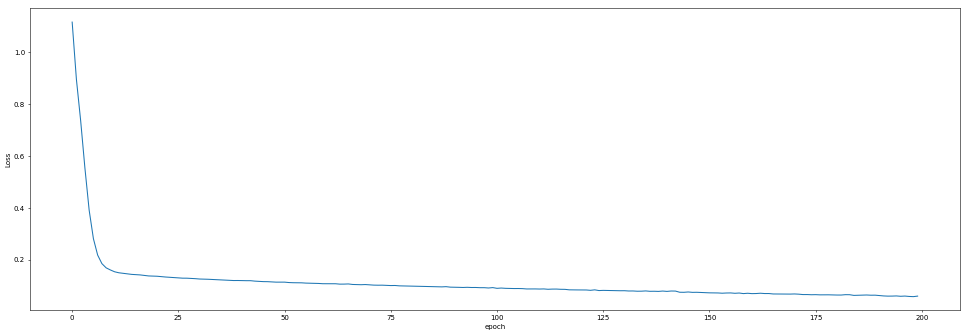

In [9]:
# 定义训练程序
test_program = fluid.default_main_program().clone(for_test=True)
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

feeder = fluid.DataFeeder(place=place, feed_list=[x, y])

losses = []
for pass_id in range(EPOCH_NUM):
    loss = []
    for batch_id, data in enumerate(train_reader()):
        train_cost = exe.run(program=fluid.default_main_program(), feed=feeder.feed(data), fetch_list=[avg_cost])   
        loss.append(train_cost[0][0]) 
    losses.append(np.mean(loss))
    if pass_id % 10==0:
        print('Epoch:', pass_id, 'loss:', np.mean(loss))

fluid.io.save_inference_model('./pd', ['x'], [pred], exe)

plt.figure(dpi=50,figsize=(24,8))
plt.plot(range(EPOCH_NUM), losses)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

## 6. 模型评估
使用评估数据评估训练好的模型，检查预测值与真实值的差异。

![](https://ai-studio-static-online.cdn.bcebos.com/37305efb9e394f2ba863081c399916380c0ca6f030464157b35ea4f92e50abe7)


In [10]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()
def convert2LODTensor(temp_arr, len_list):
    temp_arr = np.array(temp_arr) 
    temp_arr = temp_arr.flatten().reshape((-1, 1))#把测试样本的array平坦化到一维数据[N,1]的格式
    print(temp_arr.shape)
    return fluid.create_lod_tensor(
        data=temp_arr,#对测试样本来说这里表示样本的平坦化数据列表，维度为[N,1]
        recursive_seq_lens =[len_list],#对于测试样本来说这里labels列的数量
        place=fluid.CPUPlace()
        )#返回：A fluid LoDTensor object with tensor data and recursive_seq_lens info
    
def get_tensor_label(mini_batch):  
    tensor = None
    labels = []
    
    temp_arr = []
    len_list = []
    for _ in mini_batch:   #mini_batch表示测试样本数据
        labels.append(_[1]) #收集 label----y----------1维
        temp_arr.append(_[0]) #收集序列本身--x---------96维
        len_list.append(len(_[0])) #收集每个序列x的长度,和上边x的维度对应，这里全为6
    tensor = convert2LODTensor(temp_arr, len_list)    
    return tensor, labels


if flag==0: # 全连接神经网络的数据处理
    tester_reader = readers(test_x, test_y)
    test_reader = paddle.batch(tester_reader, batch_size=31)
    test_data = next(test_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
else: # LSTM 网络的数据处理
    test_x = test_x.astype("float32")
    test_y= test_y.astype("float32")
    tester_reader = readers(test_x, test_y)
    test_reader = paddle.batch(tester_reader, batch_size=31-day_num)#一次性把样本取完
    for mini_batch in test_reader():
        test_x,labels = get_tensor_label(mini_batch)#其实就是变成tensor格式的x和y
        break
    
    
print(test_x.shape)
with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names, fetch_targets] =\
        fluid.io.load_inference_model('./pd', infer_exe)
    results = infer_exe.run(inference_program,
        feed={feed_target_names[0]: test_x},
        fetch_list=fetch_targets)

(30, 480)


(30, 96)
(2880,)
(1, 30, 96)
(1, 30, 96)


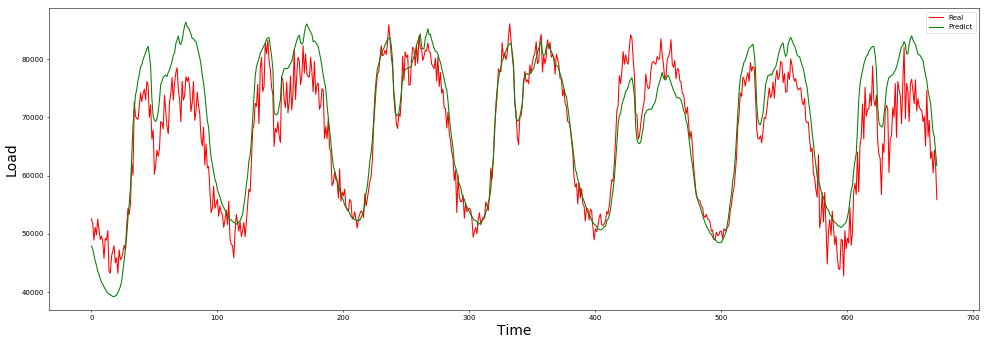

In [11]:
# print(results)
if normalization==0: 
    results= (Max_y - Min_y)*results+Min_y
    test_y=  (Max_y - Min_y)*test_y+Min_y
else:
    results = results*sgma_y+mu_y
    test_y = test_y*sgma_y + mu_y
print(test_y.shape)

y1 = np.reshape(results, (1,test_y.shape[0]*test_y.shape[1]))
y2 = np.reshape(test_y, (1,test_y.shape[0]*test_y.shape[1]))
print(y1[0, :].shape)
plt.figure(dpi=50,figsize=(24,8))
plt.plot(range(date_n*96), y1[0, :date_n*96],  color='r', label='Real')
plt.plot(range(date_n*96), y2[0, :date_n*96], color='g', label='Predict')  #绿线为预测值
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Load', fontsize = 20)
plt.legend()
plt.show()

print(results.shape)
# print(test_y)
s = "真值-预测分割线 "
# print("{:*^90}".format(s))
# print(results)
mape = np.mean(np.abs((results - test_y) / test_y)) * 100
error = abs(results - test_y)
# print(mape)
print(results.shape)
test_y.resize((31-day_num,96))
results.resize((31-day_num,96))
error.resize((31-day_num,96))
# print(mape)
# print(error)


## 7. 模型预测
利用模型对30天后的用电量进行预测，展示效果如下。

![](https://ai-studio-static-online.cdn.bcebos.com/368aa0d887544cc3900633dc45f3e83aa77db0e5ddcf4ac9b121ea1f9939ed53)
![](https://ai-studio-static-online.cdn.bcebos.com/f16cd1257ff646ea8f5bd46be539a9fa2eafc371b95a443a9d6f51ec8e54aba0)


<Figure size 480x480 with 0 Axes>

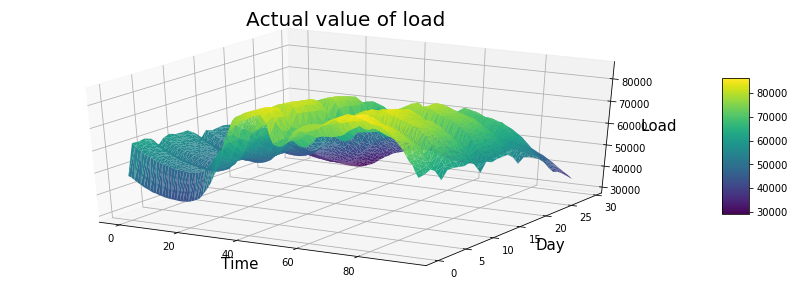

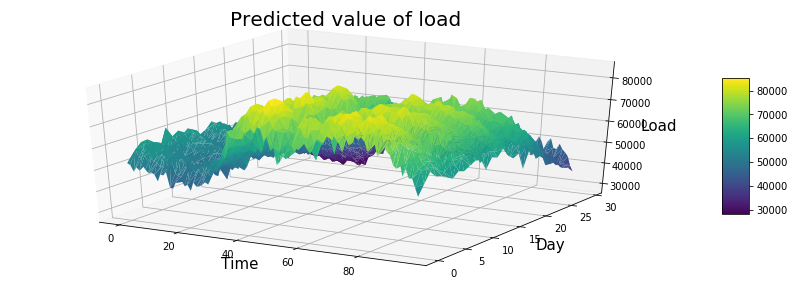

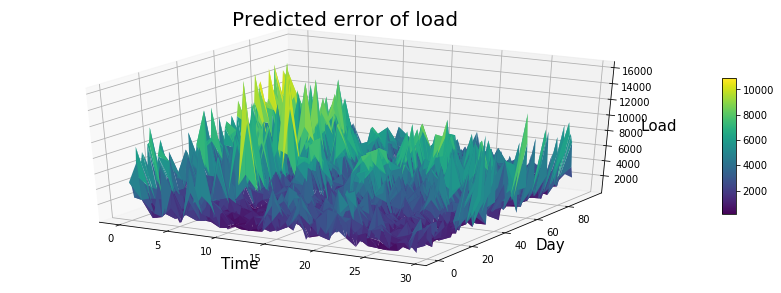

In [12]:
df_test_y = pd.DataFrame(test_y)
df_results = pd.DataFrame(results)
df_error = pd.DataFrame(error)
# print(df_results)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
data = df_test_y
df=data.unstack().reset_index() 
df.columns=["X","Y","Z"]
 
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
fig = plt.figure(figsize=(15,5))
ax = fig.gca(projection='3d')
#交换X,Y,可以旋转90度
surf=ax.plot_trisurf(df['X'], df['Y'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
# surf=surf.rotate(90)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Day', fontsize = 15)
ax.set_zlabel('Load', fontsize = 15)
ax.set_title('Actual value of load', fontsize = 20)

plt.show()
#********************
data = df_results
df=data.unstack().reset_index() 
df.columns=["X","Y","Z"]
 
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
fig = plt.figure(figsize=(15,5))
ax = fig.gca(projection='3d')
#交换X,Y,可以旋转90度
surf=ax.plot_trisurf(df['X'], df['Y'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
# surf=surf.rotate(90)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Day', fontsize = 15)
ax.set_zlabel('Load', fontsize = 15)
ax.set_title('Predicted value of load', fontsize = 20)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()
#********************
data = df_error
df=data.unstack().reset_index() 
df.columns=["X","Y","Z"]
 
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
fig = plt.figure(figsize=(15,5))
ax = fig.gca(projection='3d')
# ax = fig.gca(projection='2d')
#交换X,Y,可以旋转90度
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
# surf=surf.rotate(90)
# cax = ax.matshow(surf,  cmap='GnBu')
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Day', fontsize = 15)
ax.set_zlabel('Load', fontsize = 15)
ax.set_title('Predicted error of load', fontsize = 20)
fig.colorbar( surf, shrink=0.5, aspect=10)
plt.show()
#********************画误差图

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instruction``s. 